# Tarea 4 Clasificación

- **Cristopher Corona Velasco**
- **743940**
- **Jueves 6 de Nov. de 2025**

En este ejercicio aplicarás tres modelos de clasificación:
- K-Nearest Neighbors (KNN)
- Naive Bayes
- Regresión Logística

El objetivo es detectar un hongo es comestible o venenoso según sus especificaciones como la forma del sombrero, el color del sombrero, el color de las branquias, etc.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB


df = pd.read_csv("/Users/cristophercoronavelasco/Desktop/Ciencia de Datos/Taller de Modelado de Datos/data/mushrooms.csv")
df.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [17]:
df.info()
df.describe()
print("\nNA por column:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [18]:
## Todas como variables categóricas

for col in df.columns:
    df[col] = df[col].astype("category")

## Revisamos en fa
print(df.dtypes.head())

class          category
cap-shape      category
cap-surface    category
cap-color      category
bruises        category
dtype: object


Observa como se distribuye tu variable target "class". Presenta un desbalanceo grave/moderado/bajo?

Conteos del target:
 class
e    4208
p    3916
Name: count, dtype: int64

Proporciones del target:
 class
e    0.517971
p    0.482029
Name: proportion, dtype: float64

Dsbalance de class: bajo


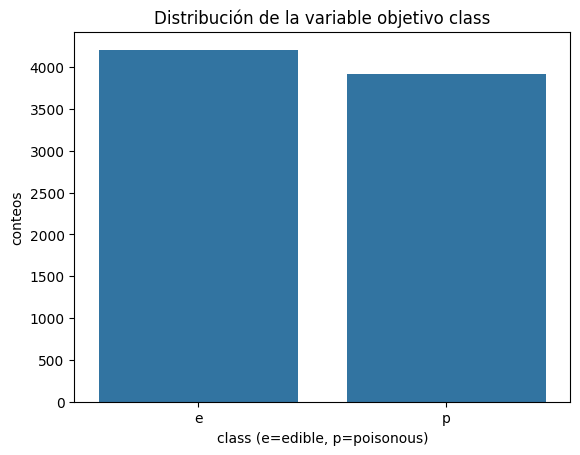

In [19]:
# 'class' es el target, 'e' = edible, 'p' = poisonous
target_counts = df['class'].value_counts()
target_ratio = df['class'].value_counts(normalize=True)

print("Conteos del target:\n", target_counts)
print("\nProporciones del target:\n", target_ratio)

# Clasificación del desbalance
minority_prop = target_ratio.min()
if minority_prop < 0.20:
    imbalance_label = "grave"
elif minority_prop < 0.30:
    imbalance_label = "moderado"
else:
    imbalance_label = "bajo"

print(f"\nDsbalance de class: {imbalance_label}")

# Gráfico rápido
sns.countplot(x='class', data=df)
plt.title("Distribución de la variable objetivo class")
plt.xlabel("class (e=edible, p=poisonous)")
plt.ylabel("conteos")
plt.show()


Asegura que tus variables sean del tipo category

In [20]:
print(df.dtypes.head())

class          category
cap-shape      category
cap-surface    category
cap-color      category
bruises        category
dtype: object


Transforma tus variables categorias, como todas las variables que tienes son categoricas, preguntate si vale la pena usar mejor one hot encoding o label encoding. 

In [21]:
## Como ya convertimos todo a category desde antes, mejor nos esperamos a dropear columnas para no hacer el encoding
## aun cuando tenemos elementos de que deshacernos

Revisa la cardinalidad de las columnas que tienes y verifica si todas aportan valor o existe alguna que puedas eliminar

In [22]:
# Cardinalidad por column
card = df.nunique().sort_values()
print("Cardinalidad por columna (valores únicos):\n", card)

# Eliminamos columnas con un solo valore
cols_single_value = [c for c in df.columns if df[c].nunique() == 1]
print("\nColumnas con un solo valor, pa borrarlas:", cols_single_value)

df = df.drop(columns=cols_single_value)


Cardinalidad por columna (valores únicos):
 veil-type                    1
class                        2
bruises                      2
gill-attachment              2
gill-spacing                 2
gill-size                    2
stalk-shape                  2
ring-number                  3
cap-surface                  4
veil-color                   4
stalk-surface-below-ring     4
stalk-surface-above-ring     4
ring-type                    5
stalk-root                   5
cap-shape                    6
population                   6
habitat                      7
stalk-color-above-ring       9
stalk-color-below-ring       9
odor                         9
spore-print-color            9
cap-color                   10
gill-color                  12
dtype: int64

Columnas con un solo valor, pa borrarlas: ['veil-type']


Divide tus datos en entrenamiento y prueba

In [23]:
# Mapeamos target a binario: poisonous (p) = 1 (positivo), edible (e) = 0
y = df['class'].map({'e': 0, 'p': 1}).astype(int)

#features
X = df.drop(columns=['class'])

# División estratificada para mantener poroporciones dle target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (6499, 21) X_test: (1625, 21)


In [24]:
# lista de columnas, todas son categoricaa
cat_cols = X_train.columns.tolist()

## Ahora si metemos onehot y no label encoding para evitar orden inventado, además de que encaja mejor con los modelos a entrenar

# one-hot con manejo de categorías no vistas
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)


Entrena los siguentes 3 modelos:
- Regresion logistica
- KNN (tunea el hiperparametro de la K)
- Naive Bayes

In [25]:
# Regresion logistica
pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42))
])

# KNN (tunea el hiperparametro de la K)
pipe_knn = Pipeline(steps=[
    ("prep", preprocess),
    ("model", KNeighborsClassifier())
])
param_grid_knn = {
    "model__n_neighbors": list(range(3, 32, 2))  # impares 3..31
}
grid_knn = GridSearchCV(
    pipe_knn,
    param_grid_knn,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

# Naive Bayes
pipe_nb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", BernoulliNB())
])


Definimos las funciones de evaluación

In [26]:
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def print_report(name, y_train, y_pred_train, y_test, y_pred_test):
    print(f"\n=== {name} | Métricas ===")
    m_tr = compute_metrics(y_train, y_pred_train)
    m_te = compute_metrics(y_test, y_pred_test)
    print(f"Train -> acc: {m_tr['accuracy']:.3f} | prec: {m_tr['precision']:.3f} | rec: {m_tr['recall']:.3f} | f1: {m_tr['f1']:.3f}")
    print(f"Test  -> acc: {m_te['accuracy']:.3f} | prec: {m_te['precision']:.3f} | rec: {m_te['recall']:.3f} | f1: {m_te['f1']:.3f}")

    print("\nReporte de clasificación (Test):")
    print(classification_report(y_test, y_pred_test, digits=3))

def plot_confusions(name, y_train, y_pred_train, y_test, y_pred_test):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{name} - Train")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot(ax=axes[1], colorbar=False)
    axes[1].set_title(f"{name} - Test")
    plt.suptitle(f"Matrices de confusión - {name}")
    plt.tight_layout()
    plt.show()

def get_proba(model, X):
    # todas las pipelines usan predict_proba
    return model.predict_proba(X)[:, 1]


Ahora si training y evaluacion de c/u


=== Regresión Logística | Métricas ===
Train -> acc: 1.000 | prec: 1.000 | rec: 1.000 | f1: 1.000
Test  -> acc: 0.999 | prec: 1.000 | rec: 0.999 | f1: 0.999

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           0      0.999     1.000     0.999       842
           1      1.000     0.999     0.999       783

    accuracy                          0.999      1625
   macro avg      0.999     0.999     0.999      1625
weighted avg      0.999     0.999     0.999      1625



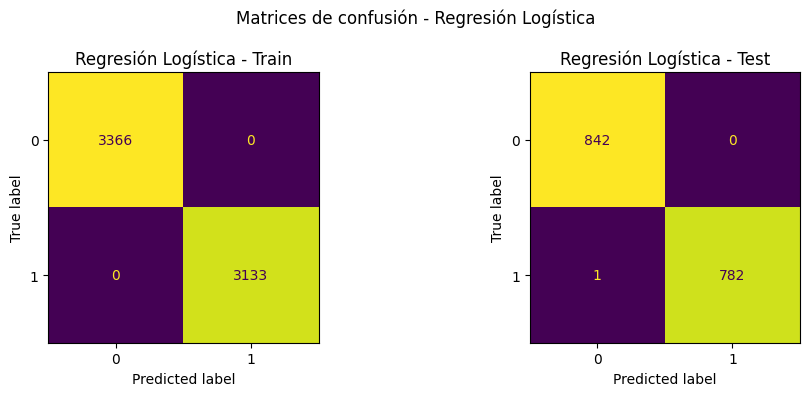

Mejor K encontrado: {'model__n_neighbors': 3}

=== KNN (mejor K) | Métricas ===
Train -> acc: 1.000 | prec: 1.000 | rec: 1.000 | f1: 1.000
Test  -> acc: 1.000 | prec: 1.000 | rec: 1.000 | f1: 1.000

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       842
           1      1.000     1.000     1.000       783

    accuracy                          1.000      1625
   macro avg      1.000     1.000     1.000      1625
weighted avg      1.000     1.000     1.000      1625



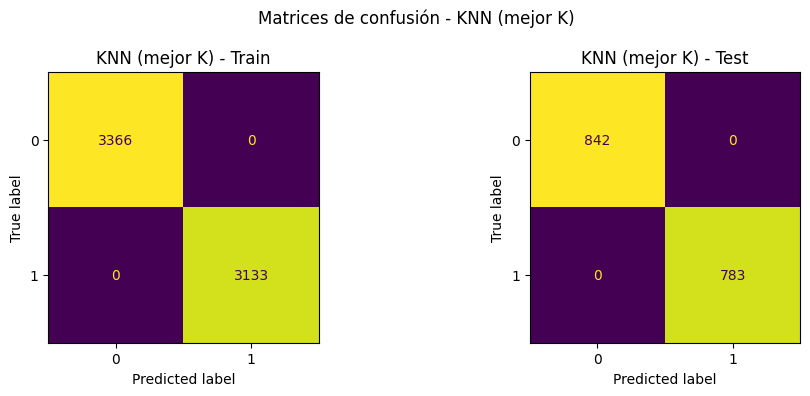


=== Naive Bayes (Bernoulli) | Métricas ===
Train -> acc: 0.942 | prec: 0.985 | rec: 0.893 | f1: 0.937
Test  -> acc: 0.933 | prec: 0.981 | rec: 0.877 | f1: 0.927

Reporte de clasificación (Test):
              precision    recall  f1-score   support

           0      0.896     0.985     0.938       842
           1      0.981     0.877     0.927       783

    accuracy                          0.933      1625
   macro avg      0.939     0.931     0.932      1625
weighted avg      0.937     0.933     0.933      1625



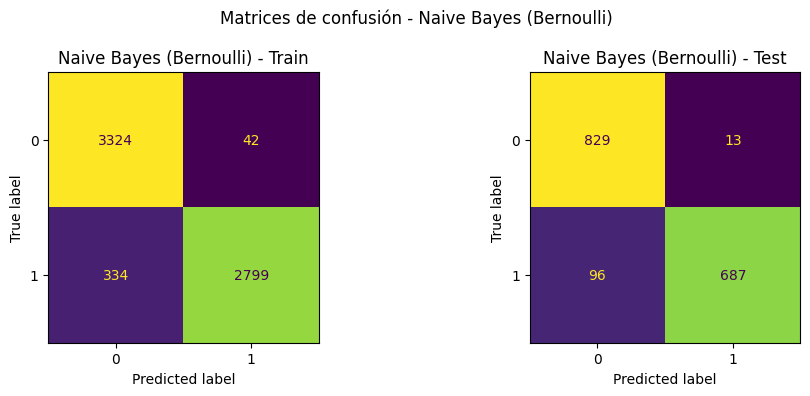

In [27]:
# Regresion logistica
pipe_lr.fit(X_train, y_train)
y_pred_tr_lr = pipe_lr.predict(X_train)
y_pred_te_lr = pipe_lr.predict(X_test)

print_report("Regresión Logística", y_train, y_pred_tr_lr, y_test, y_pred_te_lr)
plot_confusions("Regresión Logística", y_train, y_pred_tr_lr, y_test, y_pred_te_lr)

# KNN (tunea el hiperparametro de la K)
grid_knn.fit(X_train, y_train)
print("Mejor K encontrado:", grid_knn.best_params_)

best_knn = grid_knn.best_estimator_
y_pred_tr_knn = best_knn.predict(X_train)
y_pred_te_knn = best_knn.predict(X_test)

print_report("KNN (mejor K)", y_train, y_pred_tr_knn, y_test, y_pred_te_knn)
plot_confusions("KNN (mejor K)", y_train, y_pred_tr_knn, y_test, y_pred_te_knn)

# Naive Bayes
pipe_nb.fit(X_train, y_train)
y_pred_tr_nb = pipe_nb.predict(X_train)
y_pred_te_nb = pipe_nb.predict(X_test)

print_report("Naive Bayes (Bernoulli)", y_train, y_pred_tr_nb, y_test, y_pred_te_nb)
plot_confusions("Naive Bayes (Bernoulli)", y_train, y_pred_tr_nb, y_test, y_pred_te_nb)


Haz predicciones e imprime:
- Metricas en train y test
- Matriz de confusion
- Reporte de clasificacion

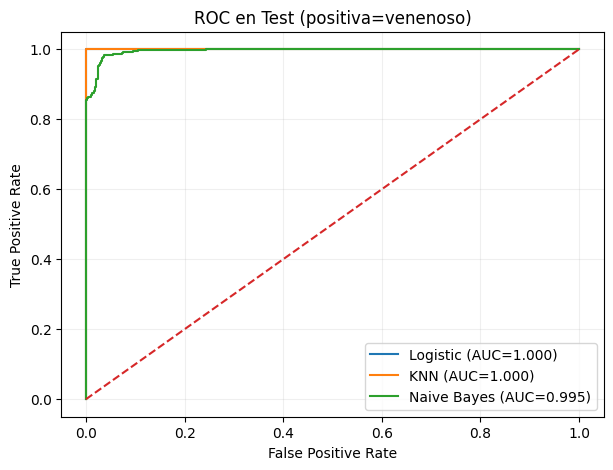

AUC en Test por modelo: {'Regresión Logística': 1.0, 'KNN (mejor K)': 1.0, 'Naive Bayes (Bernoulli)': 0.9954}
según ROC-AUC (Test): Regresión Logística


In [28]:
# Probabilidades
proba_lr_tr = get_proba(pipe_lr, X_train)
proba_lr_te = get_proba(pipe_lr, X_test)

proba_knn_tr = get_proba(best_knn, X_train)
proba_knn_te = get_proba(best_knn, X_test)

proba_nb_tr  = get_proba(pipe_nb, X_train)
proba_nb_te  = get_proba(pipe_nb, X_test)

# curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr_te)
fpr_knn, tpr_knn, _ = roc_curve(y_test, proba_knn_te)
fpr_nb, tpr_nb, _ = roc_curve(y_test, proba_nb_te)

auc_lr  = auc(fpr_lr, tpr_lr)
auc_knn = auc(fpr_knn, tpr_knn)
auc_nb  = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic (AUC={auc_lr:.3f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC={auc_knn:.3f})")
plt.plot(fpr_nb,  tpr_nb,  label=f"Naive Bayes (AUC={auc_nb:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC en Test (positiva=venenoso)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Eleccion de mejor modelo por AUC
auc_scores = {
    "Regresión Logística": auc_lr,
    "KNN (mejor K)": auc_knn,
    "Naive Bayes (Bernoulli)": auc_nb
}
best_name = max(auc_scores, key=auc_scores.get)
print("AUC en Test por modelo:", {k: round(v, 4) for k, v in auc_scores.items()})
print(f"según ROC-AUC (Test): {best_name}")


Utiliza la curva ROC para elegir el mejor modelo

En los resultados anteriores todo nos dice que KNN tuvo 0 FN, mientras que RL tuvo por lo menos una, la razon por la que nos prefiere el RL en ROC es que estan empatados a nivel de AUC, ambas en 1, y sobre todo, como se preserva el orden, nos da en primer lugar a RL, pero sabemos que no lo fue. A continuación vamos a probar un metodo de desempate considerando FN y posteriormente vamos a ver si logramos reducir los FN de RL

In [29]:
# Desempate para priorizar FN si AUC esta empatado
from sklearn.metrics import confusion_matrix

def count_fn(y_true, proba, thr=0.5):
    y_hat = (proba >= thr).astype(int)
    return confusion_matrix(y_true, y_hat)[1, 0] 

fns = {
    "Regresión Logística": count_fn(y_test, proba_lr_te, 0.5),
    "KNN (mejor K)":        count_fn(y_test, proba_knn_te, 0.5),
    "Naive Bayes (Bernoulli)": count_fn(y_test, proba_nb_te, 0.5)
}

# Si AUC están empatados, elegimos por menos FN, luego por mayor recall 
if len({round(v, 3) for v in auc_scores.values()}) == 1:
    best_name = min(fns, key=fns.get)

print("AUC en Test por modelo:", {k: round(v, 4) for k, v in auc_scores.items()})
print("Falsos negativos (Test) por modelo:", fns)
print(f"mejor modelo {best_name}")


AUC en Test por modelo: {'Regresión Logística': 1.0, 'KNN (mejor K)': 1.0, 'Naive Bayes (Bernoulli)': 0.9954}
Falsos negativos (Test) por modelo: {'Regresión Logística': np.int64(1), 'KNN (mejor K)': np.int64(0), 'Naive Bayes (Bernoulli)': np.int64(96)}
mejor modelo Regresión Logística


Umbral seguro LR: 0.4564
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       842
           1      1.000     1.000     1.000       783

    accuracy                          1.000      1625
   macro avg      1.000     1.000     1.000      1625
weighted avg      1.000     1.000     1.000      1625



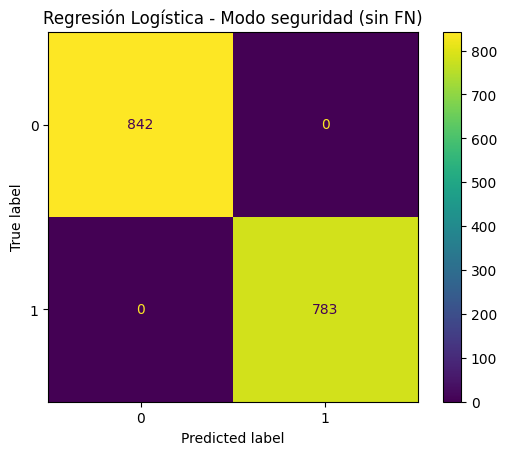

In [30]:
## Ahora intentamos bajar los FN de la RL a 0

## en primera instancia es lógico valorar que para KNN no tuvimos que modificar el umbral estandar, 
# pero cuando lo comparas a nivel de costo computacional en databases mas grandes, puede que valga la pena reconsiderar RL

# Umbral minimo que logra recall=1.0 (sin FN) con la Logística
fpr, tpr, thr = roc_curve(y_test, proba_lr_te)
import numpy as np

idx = np.where(tpr == 1.0)[0]
if len(idx) > 0:
    thr_safe = thr[idx[np.argmin(fpr[idx])]]  
else:
    thr_safe = 0.5  

y_hat_safe = (proba_lr_te >= thr_safe).astype(int)
print("Umbral seguro LR:", round(thr_safe, 4))
print(classification_report(y_test, y_hat_safe, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_safe)).plot()
plt.title("Regresión Logística - Modo seguridad (sin FN)")
plt.show()



## Conclusión

Inicialmente el método para elegir el mejor modelo fue la prueba ROC AUC, en esta tuvimos un empate de AUC en 1 para RL y KNN; NB falló por sesgo de independencia. Postriormente y calificando sobre falsos negativos, KNN tuvo un mejor resultado, teniendo 0 FN. Tambiñen en recall y FP ambos empataron.

***Entonces: ¿Cuál elegir?**

Pues en estricta teoría a KNN le fuie muy bien con un umbral standar, y esto fue lo que pudo limitar a RL, pero una vez que modificamos el umbral, RL nos dio los mismos buenos resultados. La idea es que para esta db gana KNN desde un principio, sin tener que modificar el umbral, pero si aumentaramos el tamaño de la DB, el costo computacional es exponencialmente mayor que RL, así que despues de una evaluación del umbral, podríamos aprovechar mejor RL en futuros casos.